# DEMO
Runs detection using a pretrained model, based on tools/demo.py 

Train the network by running:
#### VGG_CNN_M_1024
./tools/train_net.py --gpu 0 --iters 1000 --weights data/imagenet_models/VGG_CNN_M_1024.v2.caffemodel --imdb hands_train --cfg ./experiments/cfgs/hands_config.yml --solver models/hands/VGG_CNN_M_1024/faster_rcnn_end2end/solver.prototxt
 
#### VGG16
./tools/train_net.py --gpu 0 --iters 100 --weights data/imagenet_models/VGG16.v2.caffemodel --imdb hands_train --cfg ./experiments/cfgs/hands_config.yml --solver models/hands/VGG16/faster_rcnn_end2end/solver.prototxt

{'DATA_DIR': '/home/wilk/py-faster-rcnn/data',
 'DEDUP_BOXES': 0.0625,
 'EPS': 1e-14,
 'EXP_DIR': 'faster_rcnn_end2end',
 'GPU_ID': 0,
 'MATLAB': 'matlab',
 'MODELS_DIR': '/home/wilk/py-faster-rcnn/models',
 'PIXEL_MEANS': array([[[ 102.9801,  115.9465,  122.7717]]]),
 'RNG_SEED': 3,
 'ROOT_DIR': '/home/wilk/py-faster-rcnn',
 'TEST': {'BBOX_REG': True,
          'HAS_RPN': True,
          'MAX_SIZE': 1000,
          'NMS': 0.3,
          'PROPOSAL_METHOD': 'gt',
          'RPN_MIN_SIZE': 16,
          'RPN_NMS_THRESH': 0.7,
          'RPN_POST_NMS_TOP_N': 300,
          'RPN_PRE_NMS_TOP_N': 6000,
          'SCALES': [600],
          'SVM': False},
 'TRAIN': {'ASPECT_GROUPING': True,
           'BATCH_SIZE': 128,
           'BBOX_INSIDE_WEIGHTS': [1.0, 1.0, 1.0, 1.0],
           'BBOX_NORMALIZE_MEANS': [0.0, 0.0, 0.0, 0.0],
           'BBOX_NORMALIZE_STDS': [0.1, 0.1, 0.2, 0.2],
           'BBOX_NORMALIZE_TARGETS': True,
           'BBOX_NORMALIZE_TARGETS_PRECOMPUTED': True,
           

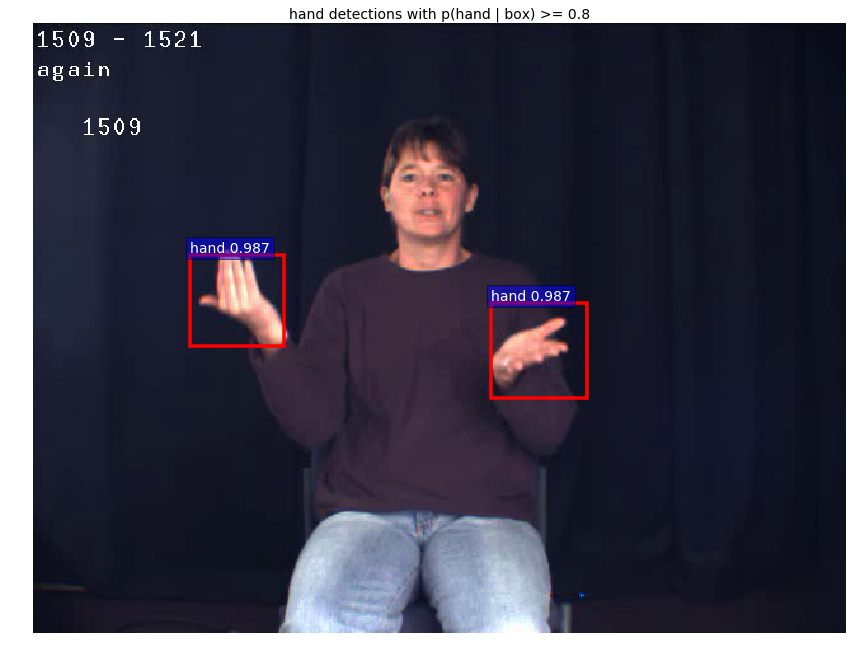

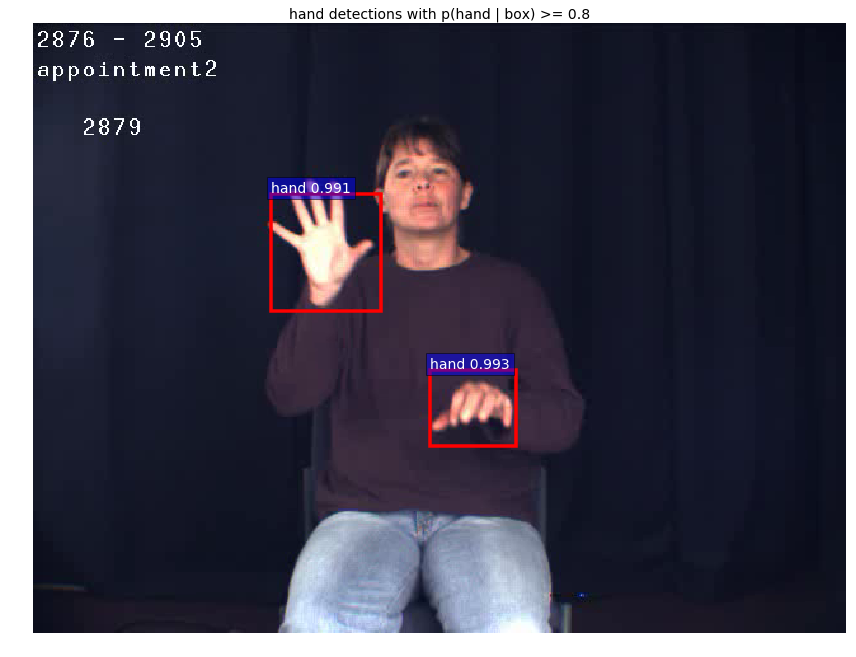

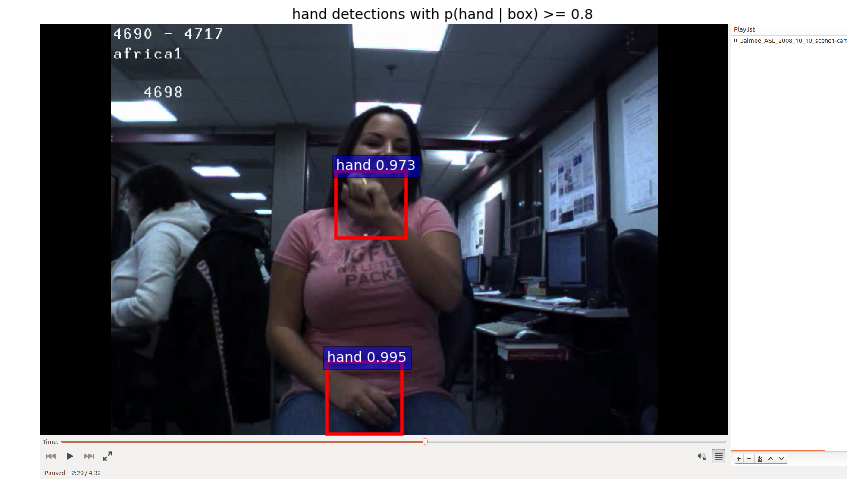

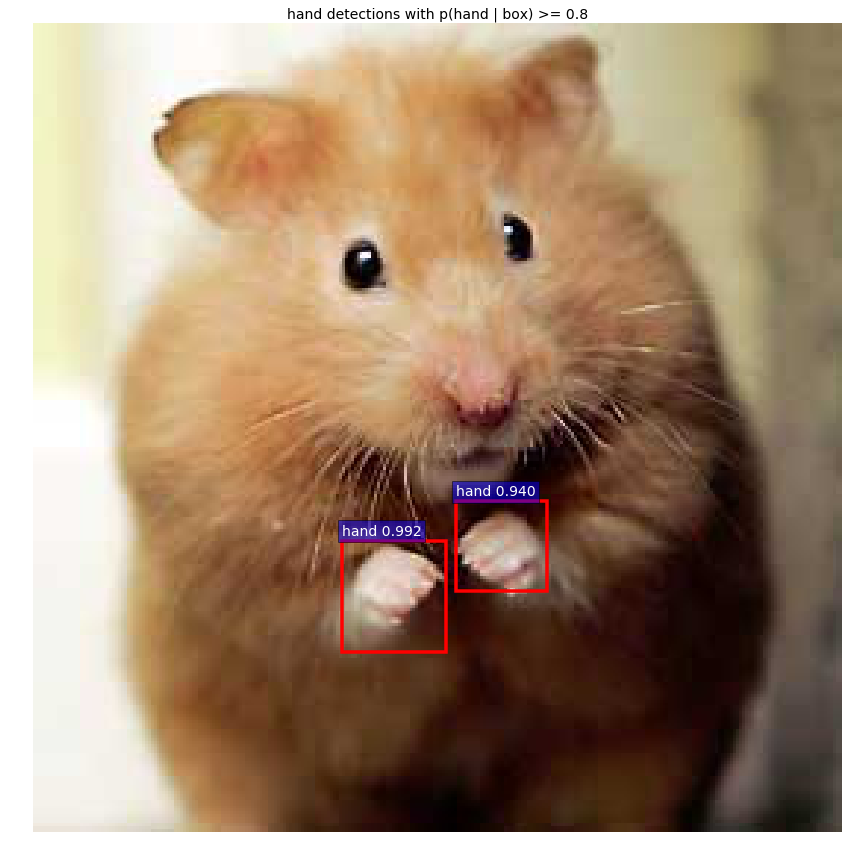

In [3]:
import sys
tools_dir = '../tools'
if tools_dir not in sys.path:
    sys.path.append(tools_dir)

import matplotlib
#print(matplotlib.get_backend())
import matplotlib.pyplot as plt

import _init_paths, caffe, os, cv2, pprint
import numpy as np
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
from fast_rcnn.config import cfg, cfg_from_file



CLASSES = ('__background__',
           'hand', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    
    ax.imshow(im, aspect='equal')

    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    

def demo(net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join(cfg.DATA_DIR, 'demo', image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(net, im)
    timer.toc()
    print ('Detection took {:.3f}s for {:d} object proposals').format(timer.total_time, boxes.shape[0])

    # Visualize detections for each class
    CONF_THRESH = 0.8
    NMS_THRESH = 0.3
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)
        
# config
CFG_FILE = '../experiments/cfgs/hands_config.yml'
cfg_from_file(CFG_FILE)

pprint.pprint(cfg)

# VGG_CNN_M_1024
#prototxt = os.path.join(cfg.ROOT_DIR, 'models', 'hands', 'VGG_CNN_M_1024', 'faster_rcnn_end2end', 'test.prototxt')
#caffemodel = os.path.join(cfg.ROOT_DIR, 'output', 'faster_rcnn_end2end', 'train', 'vgg_cnn_m_1024_faster_rcnn_iter_5000.caffemodel')
# VGG16
prototxt = os.path.join(cfg.ROOT_DIR, 'models', 'hands', 'VGG16', 'faster_rcnn_end2end', 'test.prototxt')
#caffemodel = os.path.join(cfg.ROOT_DIR, 'output', 'faster_rcnn_end2end', 'train_asl', 'vgg16_faster_rcnn_iter_10000.caffemodel')
caffemodel = os.path.join(cfg.ROOT_DIR, 'output', 'faster_rcnn_end2end', 'train_vgghands', 'vgg16_faster_rcnn_iter_5000.caffemodel')


print('prototxt: {}'.format(prototxt))
print('model: {}'.format(caffemodel))

if not os.path.isfile(caffemodel):
    raise IOError('Model file not found')

caffe.set_mode_gpu()
caffe.set_device(cfg.GPU_ID)
net = caffe.Net(prototxt, caffemodel, caffe.TEST)

im_names = ['Lana_ASL_2006_10_10_scene2-camera1_1509.png',
            'Lana_ASL_2006_10_10_scene2-camera1_2879.png',
            'jaimee.png', 'hamster.jpg']
 
for im_name in im_names:
    print '---\nDemo for data/demo/{}'.format(im_name)
    demo(net, im_name)

plt.show()

net = None